# Flocking model

Continuous-space agent interactions. [Source](https://juliadynamics.github.io/Agents.jl/stable/examples/flock/)

Each agent follows three simple rules:

+ maintain a minimum distance from other birds to avoid collision
+ fly towards the average position of neighbors
+ fly in the average direction of neighbors

In [1]:
using Agents
using Random
using LinearAlgebra
using Base64
using CairoMakie
CairoMakie.activate!(px_per_unit = 1.0)

The helper function is adapted from `Agents.abmvideo` and correctly displays animations in Jupyter notebooks

In [2]:
function abmvio(model;
    dt = 1, framerate = 30, frames = 300, title = "", showstep = true,
    figure = (size = (600, 600),), axis = NamedTuple(),
    recordkwargs = (compression = 23, format ="mp4"), kwargs...
)
    # title and steps
    abmtime_obs = Observable(abmtime(model))
    if title ≠ "" && showstep
        t = lift(x -> title*", time = "*string(x), abmtime_obs)
    elseif showstep
        t = lift(x -> "time = "*string(x), abmtime_obs)
    else
        t = title
    end

    axis = (title = t, titlealign = :left, axis...)
    # First frame
    fig, ax, abmobs = abmplot(model; add_controls = false, warn_deprecation = false, figure, axis, kwargs...)
    resize_to_layout!(fig)
    # Animation
    Makie.Record(fig; framerate, recordkwargs...) do io
        for j in 1:frames-1
            recordframe!(io)
            Agents.step!(abmobs, dt)
            abmtime_obs[] = abmtime(model)
        end
        recordframe!(io)
    end
end

abmvio (generic function with 1 method)

This agents has also three properties inherited from ContinuousAgent

+ id : unique identifier
+ pos : XY coordinate
+ vel: XY velocity

In [3]:
@agent struct Bird(ContinuousAgent{2,Float64})
    speed::Float64
    cohere_factor::Float64
    separation::Float64
    separate_factor::Float64
    match_factor::Float64
    visual_distance::Float64
end

Model factory function

In [4]:
function initialize_model(;
    n_birds = 100,
    speed = 1.5,
    cohere_factor = 0.1,
    separation = 2.0,
    separate_factor = 0.25,
    match_factor = 0.04,
    visual_distance = 5.0,
    extent = (100, 100),
    seed = 2024,
)
    space2d = ContinuousSpace(extent; spacing = visual_distance/1.5)
    rng = Random.MersenneTwister(seed)

    model = StandardABM(Bird, space2d; rng, agent_step!, scheduler = Schedulers.Randomly())
    for _ in 1:n_birds
        vel = rand(abmrng(model), SVector{2}) * 2 .- 1
        add_agent!(
            model,
            vel,
            speed,
            cohere_factor,
            separation,
            separate_factor,
            match_factor,
            visual_distance,
        )
    end
    return model
end

initialize_model (generic function with 1 method)

Stepping function

In [5]:
function agent_step!(bird, model)
    # Obtain the ids of neighbors within the bird's visual distance
    neighbor_ids = nearby_ids(bird, model, bird.visual_distance)
    N = 0
    match = separate = cohere = (0.0, 0.0)
    # Calculate behaviour properties based on neighbors
    for id in neighbor_ids
        N += 1
        neighbor = model[id].pos
        heading = get_direction(bird.pos, neighbor, model)

        # `cohere` computes the average position of neighboring birds
        cohere = cohere .+ heading
        if euclidean_distance(bird.pos, neighbor, model) < bird.separation
            # `separate` repels the bird away from neighboring birds
            separate = separate .- heading
        end
        # `match` computes the average trajectory of neighboring birds
        match = match .+ model[id].vel
    end

    N = max(N, 1)
    # Normalise results based on model input and neighbor count
    cohere = cohere ./ N .* bird.cohere_factor
    separate = separate ./ N .* bird.separate_factor
    match = match ./ N .* bird.match_factor
    # Compute velocity based on rules defined above
    bird.vel = (bird.vel .+ cohere .+ separate .+ match) ./ 2
    bird.vel = bird.vel ./ norm(bird.vel)
    # Move bird according to new velocity and speed
    move_agent!(bird, model, bird.speed)
end

agent_step! (generic function with 1 method)

## Visualization

In [6]:
const bird_polygon = Makie.Polygon(Point2f[(-1, -1), (2, 0), (-1, 1)])
function bird_marker(b::Bird)
    φ = atan(b.vel[2], b.vel[1]) ##+ π/2 + π
    rotate_polygon(bird_polygon, φ)
end

bird_marker (generic function with 1 method)

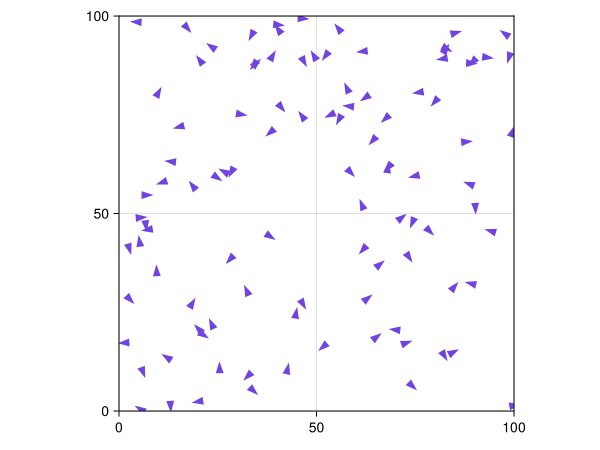

In [7]:
model = initialize_model()
figure, _ = abmplot(model; agent_marker = bird_marker)
figure

Animation

In [8]:
vio = abmvio(
    model;
    agent_marker = bird_marker,
    framerate = 20, frames = 150,
    title = "Flocking",
)
save("flocking.mp4", vio)
vio |> display

Makie.VideoStream(Base.PipeEndpoint(RawFD(4294967295) closed, 0 bytes waiting), Process(setenv(`/home/runner/.julia/artifacts/fdb14f7b1bf6766687af4e3951c4d982cee66086/bin/ffmpeg -y -loglevel quiet -threads 4 -framerate 20 -pixel_format rgb24 -f rawvideo -s:v 600x600 -r 20 -i pipe:0 -vf vflip -profile:v high422 -crf 23 -preset slow -c:v libx264 -pix_fmt yuv420p -an '/tmp/jl_xdcf9P/##video#228.mp4'`,["JULIA_CI=true", "PATH=/home/runner/.julia/artifacts/b8a470e4553346122607f94ec60d83c77f061cd6/bin:/home/runner/.julia/artifacts/7f882b869c126a717e15be05453b83bd9135eab0/bin:/home/runner/.julia/artifacts/96bc7b9ddb319d1a051535c85184aa2bf42dbd8b/bin:/home/runner/.julia/artifacts/bd752d7807f5f10e2dce3d2b2b683589fa03d31a/bin:/home/runner/.julia/artifacts/c8a20a2030f10b70947d8d2a6bff7f8b5f343fe9/bin:/home/runner/.julia/artifacts/0b5269206a6849e48487ed04136c30b1f12443e7/bin:/home/runner/.julia/artifacts/bdb4015047b09c6ac5002f73dfd5be8ddf59189b/bin:/home/runner/.julia/artifacts/00023f2f62a04af7531278ce1a689ff93800ffa1/bin:/home/runner/.julia/artifacts/8be4b2d49ed77db4f9607e5f8a7b09cc105be2ee/bin:/home/runner/.julia/artifacts/fdb14f7b1bf6766687af4e3951c4d982cee66086/bin:/opt/hostedtoolcache/julia/1.10.8/x64/bin:/home/runner/.local/bin:/opt/hostedtoolcache/uv/0.6.5/x86_64:/opt/hostedtoolcache/Python/3.13.2/x64/bin:/opt/hostedtoolcache/Python/3.13.2/x64:/snap/bin:/home/runner/.local/bin:/opt/pipx_bin:/home/runner/.cargo/bin:/home/runner/.config/composer/vendor/bin:/usr/local/.ghcup/bin:/home/runner/.dotnet/tools:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin", "DOTNET_SKIP_FIRST_TIME_EXPERIENCE=1", "GITHUB_RUN_NUMBER=519", "GITHUB_REF_NAME=main", "RUNNER_ARCH=X64", "STATS_PIP=false", "PERFLOG_LOCATION_SETTING=RUNNER_PERFLOG", "LD_LIBRARY_PATH=/home/runner/.julia/artifacts/715b660f53eb83c33e199a44ececfd8dc03f2a27/lib:/opt/hostedtoolcache/julia/1.10.8/x64/bin/../lib/julia:/home/runner/.julia/artifacts/a0f4f1441f9fabbc6b0c3a1bf38bfa415fce0bab/lib:/home/runner/.julia/artifacts/b8a470e4553346122607f94ec60d83c77f061cd6/lib:/home/runner/.julia/artifacts/5acd766faaca59c3c1f3cfa67e2bf6dcf1e3e883/lib:/home/runner/.julia/artifacts/08ab7db13fbc32076a77781b2f8bd372cf4c9a8d/lib:/home/runner/.julia/artifacts/7f882b869c126a717e15be05453b83bd9135eab0/lib:/home/runner/.julia/artifacts/dc526f26fb179a3f68eb13fcbe5d2d2a5aa7eeac/lib:/home/runner/.julia/artifacts/812bb7cf607c01b79ab9407ffed3a3e924c1af83/lib:/home/runner/.julia/artifacts/6d8a1f48d4b47dc03fa048d88680be84ae15e5fc/lib:/home/runner/.julia/artifacts/b3ddd583e7aec92a77cf5961fad01fd7063c1d40/lib:/home/runner/.julia/artifacts/a519848f1b879f273f247aaaa2af123f730d84fa/lib:/home/runner/.julia/artifacts/2b18d04d0b7fdaa8e5ddbf432b44048a3571f05b/lib:/home/runner/.julia/artifacts/96bc7b9ddb319d1a051535c85184aa2bf42dbd8b/lib:/home/runner/.julia/artifacts/bd752d7807f5f10e2dce3d2b2b683589fa03d31a/lib:/home/runner/.julia/artifacts/0a1006d282bce91b5cd408c714cbb95d3bb4f515/lib:/home/runner/.julia/artifacts/59eff635528e6914e1a96db241e950195574903b/lib:/home/runner/.julia/artifacts/2bb2b0081086bcb24e6bd287b7416b6b61d856a3/lib:/home/runner/.julia/artifacts/d632a0145c0b967e10f0612438e65bf33ce26882/lib:/home/runner/.julia/artifacts/2b9ac56bc0585f3b03cd92f988f0d07c6ab12822/lib:/home/runner/.julia/artifacts/8223b86c51229362d4689de6a5127d0b80ea77bd/lib:/home/runner/.julia/artifacts/e2512e1cd411449b9bede7b4294c7409c9973345/lib:/home/runner/.julia/artifacts/d4f3ff9736df0dda120f8dc1d27174b0d5696fb1/lib:/home/runner/.julia/artifacts/eb13375496c29fe52101a0e6710c54ff87aa0e20/lib:/home/runner/.julia/artifacts/3ded11a619b50414af902abd0a7a5bb6426b5b92/lib:/home/runner/.julia/artifacts/bd1f25e7053ebc00ee7d82f3c5ec4cf1e9a51e17/lib:/home/runner/.julia/artifacts/cf5d5f8a6109be3f9c460a39768f57a3e53ff11d/lib:/home/runner/.julia/artifacts/c8a20a2030f10b70947d8d2a6bff7f8b5f343fe9/lib:/home/runner/.julia/artifacts/0631e2a6a31b5692eec7a575836451b16b734ec0/lib:/home/runner/.julia/artifacts/4abd05

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*